In [1]:
import sympy
from sympy.core.symbol import symbols, Symbol
from sympy import Abs
from sympy.printing import latex, pprint
from sympy import Symbol, simplify, collect, expand, apart
from sympy import dsolve, Function, Derivative, integrate, diff
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, EngFormatter

from math import log10
from PyLTSpice import LTSpice_RawRead
from math import log10
import logging
from ipywidgets import FloatSlider, FloatLogSlider, interact, interactive
from converter5 import *
from scipy.optimize import minimize

Found Numpy. WIll be used for storing data


In [3]:
Lf = symbols('L_f', real=True, positive=True)
Cf = symbols('C_f' ,real=True, positive=True)
Cd = symbols('C_d', real=True, positive=True)
Vg = symbols('V_g' ,real=True, positive=True)
Rd = symbols('R_d' ,real=True, positive=True)
s = symbols('s')
j = sympy.sqrt(-1)
w = symbols('omega')
Z_Lf = s*Lf
Z_Cf = 1/(s*Cf)
Z_Cd = 1/(s*Cd)


In [4]:
def parallel(x, y):
    return x*y/(x+y)


In [7]:
Zb = parallel(Z_Cf, Z_Cd+Rd)
Zt = Z_Lf
Vout = Vg * Zb/(Zb+Zt)
Vout = Vout.simplify()
display(Vout)
#Vout = Vout.subs({s:j*w})
#display(Vout)
#display(collect(Abs(Vout), j))
#display(expand(Abs(Vout)))

V_g*(C_d*R_d*s + 1)/(C_d*R_d*s + L_f*s**2*(C_d*C_f*R_d*s + C_d + C_f) + 1)

In [ ]:
latex(Vout)

In [ ]:
c1, c2 = symbols('c_1, c_2')
x, y = symbols('x, y')
exp = (x*y*s + 1)/(s**3*(a*b*x*y)+s**2*a*(x+b)+s*x*y+1)
latex(exp)

In [10]:

max_f = 1e6
min_f = 1e2
freqs_f = np.logspace(np.log10(min_f), np.log10(max_f)) # freqs in Hz
freqs_w = 2*np.pi*freqs_f 
def mag(Rd_, Cd_):
    #freqs = 2*pi*np.logspace(100)
    
    Vout_ = Vout.subs({Vg:1, Cf: 1e-6, Lf:1e-6, Rd: Rd_, Cd:Cd_})
    t = lambdify(list(Vout_.atoms(Symbol)), Vout_)
    return 20*np.log10(np.abs(t(j*freqs_w)).astype(np.float64))
def phase(Rd_, Cd_):

    Vout_ = Vout.subs({Vg:1, Cf: 1e-6, Lf:1e-6, Rd: Rd_, Cd:Cd_})
    t = lambdify(list(Vout_.atoms(Symbol)), Vout_)
    return np.angle(t(freqs).astype(complex), deg=True)
    

<IPython.core.display.Javascript object>


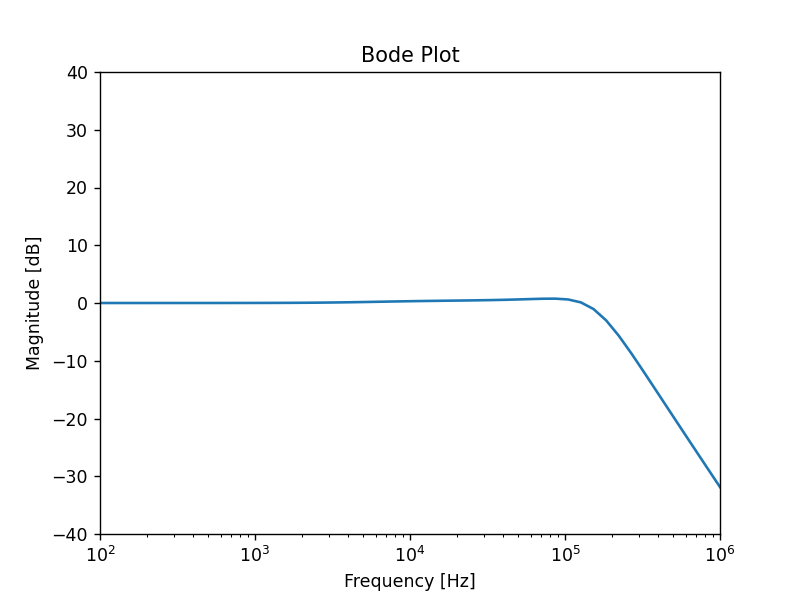

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='Rd_', max=2.0, min=0.01, r…

In [11]:
%matplotlib notebook
#doesn't work with inline backend

max_R = 2
min_R = .01
max_C =40e-6
min_C = 1e-6
r_widget = FloatSlider(min=min_R, max=max_R, step=.02, readout_format='.3f', continuous_update=False)
c_widget = FloatSlider(min=min_C, max=max_C, step=10e-6, readout_format='.1e', continuous_update=False)

fig, ax = plt.subplots(subplot_kw={'title':'Bode Plot'})
ax.set_ylim(bottom= -40, top=40)
ax.set_xlim(left=100, right=1e6)
ax.set_ylabel('Magnitude [dB]')
ax.set_xlabel('Frequency [Hz]')
#ax.xgrid()
l, = ax.semilogx(freqs_f, mag(min_R, min_C))
def g(Rd_, Cd_):
    
    l.set_ydata(mag(Rd_, Cd_))
    fig.canvas.draw()

interactive_plot = interactive(g, Rd_ = r_widget, Cd_=c_widget)
interactive_plot

In [ ]:
#Vout = Vout.subs({Vg:1, Cf: 10e-6, Lf:1e-6, Rd: 1, Cd:1e-6})
t = lambdify([Rd, Cd], Vout.subs({Vg:1, Cf: 10e-6, Lf:1e-6, s: j*50e3}))
def newt(x):
    return np.abs(t(x[0], x[1]))
    

In [ ]:
t?

In [ ]:

minimize(newt, [1, 80e-6], bounds = [(1e-3, 3), (.1e-6, 30e-6)])

In [ ]:
Rd_ = np.linspace(min_R, max_R, 10)
Cd_ = np.linspace(min_C, max_C, 10)
Rd_, Cd_ = np.meshgrid(Rd_, Cd_)

def mag2(s_):
    Vout_ = Vout.subs({Vg:1, Cf: 10e-6, Lf:1e-6,s:s_})#, Rd: Rd_, Cd:Cd_})
    t = lambdify([Rd, Cd], Vout_)
    return 20*np.log10(np.abs(t(Rd_, Cd_)))#.astype(np.float64)))

In [ ]:
Cd_[:,0]

In [ ]:

ax = plt.figure().add_subplot(projection='3d')
ans = mag2(j*5e4/(2*np.pi))
polyc = ax.plot_surface(Rd_, Cd_,ans , linewidth=0.2, antialiased=True)
ax.set_zlim(-20, 20)
ax.set_zlabel('Magnitude [dB]')
ax.set_xlabel('R damp')
ax.set_ylabel('C damp [\u03BCF]')

major_formatter= FuncFormatter(lambda val, pos: f'{val*1e6:.0f}')
ax.yaxis.set_major_formatter(major_formatter)   

major_formatter= EngFormatter(unit='\u03A9', places=1, sep='')
ax.xaxis.set_major_formatter(major_formatter)   

freq_widget = FloatLogSlider(min=3, max=5, step=.1, readout_format='.2e', continuous_update=False)
def h(freq):
    #freq in Hz
    ax.collections = []
    ax.plot_surface(Rd_, Cd_, mag2(j*freq*(2*np.pi)) , linewidth=0.2, antialiased=True)

    ax.figure.canvas.draw()

interactive_plot = interactive(h, freq=freq_widget)
interactive_plot

In [ ]:
ax.collections = []
ax.plot_surface(Rd_, Cd_,np.ones(ans.shape) , linewidth=0.2, antialiased=True)

ax.figure.canvas.draw()

In [ ]:
#ax.__dir__()

In [ ]:
ax.plot_surface(Rd_, Cd_,np.ones(ans.shape) , linewidth=0.2, antialiased=True)

In [ ]:
x, y, z = symbols('x y z')
expr = x*y + z
f = lambdify([x, y,z], expr)#.subs({z:2}))
x_ = np.arange(3)
y_ = np.arange(3)
X, Y = np.meshgrid(x_, y_)
def g(z):

    return f(X,Y, z)
g(3)

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(X,Y, g(3), linewidth=0.2, antialiased=True)


In [ ]:
x, y, z = symbols('x y z')
expr = x*y + z
f = lambdify([x, y,z], expr)#.subs({z:2}))
x_ = np.arange(3)
y_ = np.arange(3)
#X, Y = np.meshgrid(x_, y_)
def g(z):

    return f(X,Y, z)
g(3)

In [ ]:
x, y, z = symbols('x y z')
expr = x*y + z
f = lambdify([x, y], expr.subs({z:2}))
def g(xy):
    k = xy.shape[1]
    a = np.ndarray((k,k))
    for j in range(k): 
        for i in range(k):
            a[j, i] = f(xy[0, j], xy[1, i])
    return a

            
x = np.linspace(0, 4, 5)
y = np.linspace(10, 12, 5)
xy = np.array([x,y])  
g(xy)

In [ ]:
x = np.linspace(0, 4, 5)
y = np.linspace(10, 12, 5)
xy = np.array([x,y])
print(x)
print(y)
print(xy.shape)

In [ ]:
g(xy)

In [ ]:
x, y, z = symbols('x y z')
expr = x*y + z
f = lambdify(x, expr.subs({z:2, y:4}))
x = np.linspace(1, 4, 5)
f(x)

In [ ]:
n_radii = 8
n_angles = 36

# Make radii and angles spaces (radius r=0 omitted to eliminate duplication).
radii = np.linspace(0.125, 1.0, n_radii)
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)[..., np.newaxis]

# Convert polar (radii, angles) coords to cartesian (x, y) coords.
# (0, 0) is manually added at this stage,  so there will be no duplicate
# points in the (x, y) plane.
x = np.append(0, (radii*np.cos(angles)).flatten())
y = np.append(0, (radii*np.sin(angles)).flatten())

# Compute z to make the pringle surface.
z = np.sin(-x*y)

ax = plt.figure().add_subplot(projection='3d')

polyc = ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)

plt.show()

In [ ]:
%matplotlib widget
# aka import ipympl


plt.plot([0, 1, 2, 2])
plt.show()